In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.io.shapereader as shpreader
import pandas as pd
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from warnings import filterwarnings
filterwarnings('ignore')
import calendar

In [2]:
xr.open_mfdataset('C:\\Users\\USER\\Desktop\\QUAMHI\\FINAL YEAR PROJECT\\UTCI ANALYSIS\\UTCI\\*.nc')

<xarray.Dataset>
Dimensions:  (time: 350637, lon: 21, lat: 35)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 ... 2020-12-31T23:00:00
  * lon      (lon) float64 -3.5 -3.25 -3.0 -2.75 -2.5 ... 0.5 0.75 1.0 1.25 1.5
  * lat      (lat) float64 12.5 12.25 12.0 11.75 11.5 ... 5.0 4.75 4.5 4.25 4.0
Data variables:
    utci     (time, lat, lon) float32 dask.array<chunksize=(8760, 35, 21), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 1.9.9rc1 (https...
    Conventions:               CF-1.6
    history:                   Thu Aug 18 07:46:17 2022: cdo mergetime /home/...
    institution:               European Centre for Medium-Range Weather Forec...
    cdo_openmp_thread_number:  8
    NCO:                       netCDF Operators version 4.7.8 (Homepage = htt...
    CDO:                       Climate Data Operators version 1.9.9rc1 (https...

In [3]:
data= xr.open_mfdataset('C:\\Users\\USER\\Desktop\\QUAMHI\\FINAL YEAR PROJECT\\UTCI ANALYSIS\\UTCI\\*.nc')
data=data.where(data !=-99.0)

In [4]:
# Convert the UTCI values from Kelvin to Celsius
data['utci'] = data['utci'] - 273.15

In [5]:
utci = data['utci']
time = data['time']

In [6]:
locations = {
    'ACCRA': {'lat': 5.6037, 'lon': -0.187},
    'KUMASI': {'lat': 6.693, 'lon': -1.622},
    'KINTAMPO': {'lat': 8.056, 'lon': -1.730},
    'KOFORIDUA': {'lat': 6.0941, 'lon': -0.2591},
    'SUNYANI': {'lat': 7.3392, 'lon': -2.3268},
    'TARKWA': {'lat': 5.3076, 'lon': -1.9847}
}

# Colors for each location
colors = {
    'ACCRA': 'blue',
    'KUMASI': 'red',
    'KINTAMPO': 'green',
    'KOFORIDUA': 'purple',
    'SUNYANI': 'orange',
    'TARKWA': 'brown'
}

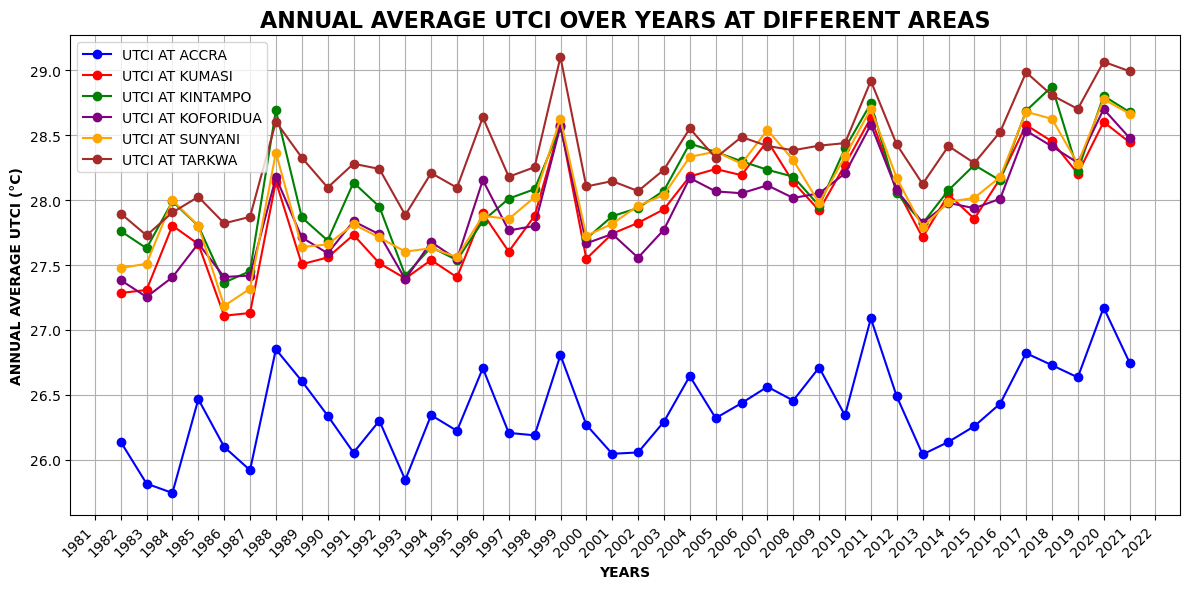

In [7]:
plt.figure(figsize=(12, 6))

for location, coords in locations.items():
    latitudes = data['lat'].values.astype(np.float64)
    longitudes = data['lon'].values.astype(np.float64)

    lat_idx = np.argmin(np.abs(latitudes - coords['lat']))
    lon_idx = np.argmin(np.abs(longitudes - coords['lon']))

    utci_location = data['utci'][:, lat_idx, lon_idx]
    utci_annual = utci_location.resample(time='Y').mean(dim='time')

    plt.plot(utci_annual['time'], utci_annual, marker='o', color=colors[location], label=f'UTCI AT {location.upper()}')


ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, ha='right')
plt.xlabel('YEARS', fontweight='bold')
plt.ylabel('ANNUAL AVERAGE UTCI (°C)', fontweight='bold')
plt.title('ANNUAL AVERAGE UTCI OVER YEARS AT DIFFERENT AREAS', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig('ANNUAL_AVERAGE_UTCI.png')
plt.show()

# AVERAGE MONTHLY UTCI

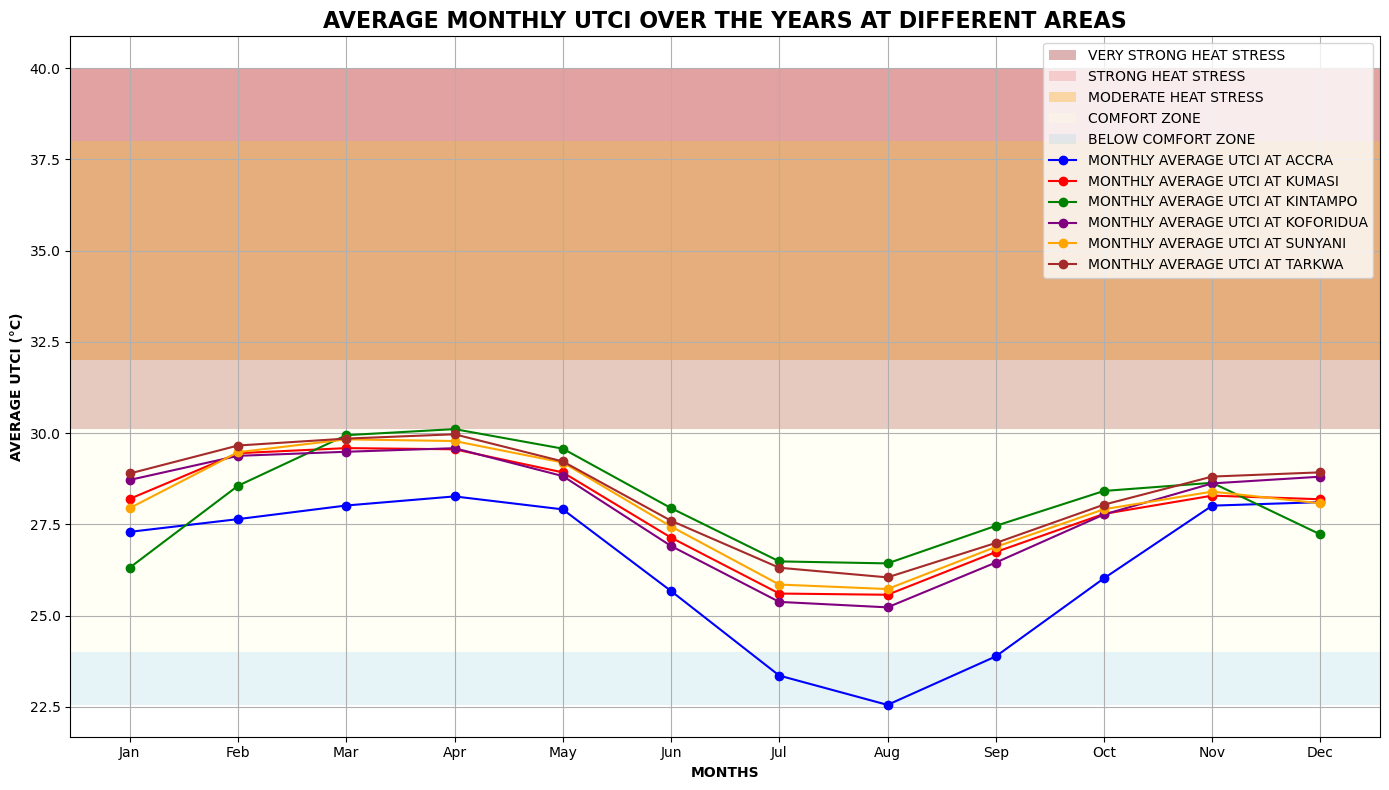

In [8]:
utci_monthly_avg = {}
for location, coords in locations.items():
    lat = coords['lat']
    lon = coords['lon']
    
    # Convert latitude and longitude to numpy arrays
    latitudes = data['lat'].values.astype(np.float64)
    longitudes = data['lon'].values.astype(np.float64)

    # Find the nearest latitude and longitude indices
    lat_idx = np.argmin(np.abs(latitudes - lat))
    lon_idx = np.argmin(np.abs(longitudes - lon))

    # Extract the UTCI data for the selected location
    utci_location = data['utci'][:, lat_idx, lon_idx]
    utci_location_da = xr.DataArray(utci_location, coords=[data.time], dims=["time"])
    utci_monthly_location = utci_location_da.resample(time='M').mean()
    utci_monthly_avg_location = utci_monthly_location.groupby(utci_monthly_location.time.dt.month).mean()
    utci_monthly_avg[location] = utci_monthly_avg_location

# Convert time to a NumPy array
months = np.arange(1, 13)
month_names = [calendar.month_abbr[m] for m in months]

# Define ranges for UTCI levels and corresponding face colors
comfort_zone_threshold = 24  # Comfort zone
moderate_heat_stress_threshold = 32  # Moderate heat stress
strong_heat_stress_threshold = 38  # Strong heat stress
very_strong_heat_stress_threshold = 40  # Very strong heat stress (Heat stroke)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Add background colors for thresholds
ax.axhspan(very_strong_heat_stress_threshold, max([utci_monthly_avg[loc].max() for loc in locations]), facecolor='darkred', alpha=0.3, label='VERY STRONG HEAT STRESS')
ax.axhspan(strong_heat_stress_threshold, very_strong_heat_stress_threshold, facecolor='lightcoral', alpha=0.3, label='STRONG HEAT STRESS')
ax.axhspan(moderate_heat_stress_threshold, strong_heat_stress_threshold, facecolor='orange', alpha=0.3, label='MODERATE HEAT STRESS')
ax.axhspan(comfort_zone_threshold, moderate_heat_stress_threshold, facecolor='lightyellow', alpha=0.3, label='COMFORT ZONE')
ax.axhspan(min([utci_monthly_avg[loc].min() for loc in locations]), comfort_zone_threshold, facecolor='lightblue', alpha=0.3, label='BELOW COMFORT ZONE')

# Plot the monthly average UTCI for each location
for location, color in colors.items():
    ax.plot(months, utci_monthly_avg[location], marker='o', color=color, label=f'MONTHLY AVERAGE UTCI AT {location.upper()}')

# Format the x-axis
ax.set_xticks(months)
ax.set_xticklabels(month_names)
ax.set_xlabel('MONTHS', fontweight='bold')
ax.set_ylabel('AVERAGE UTCI (°C)', fontweight='bold')
ax.set_title('AVERAGE MONTHLY UTCI OVER THE YEARS AT DIFFERENT AREAS', fontsize=16, fontweight='bold')
ax.legend()
ax.grid(True)
plt.tight_layout()
#plt.savefig('AVERAGE_MONTHLY_UTCI.png')
plt.show()

# AVERAGE HOURLY UTCI

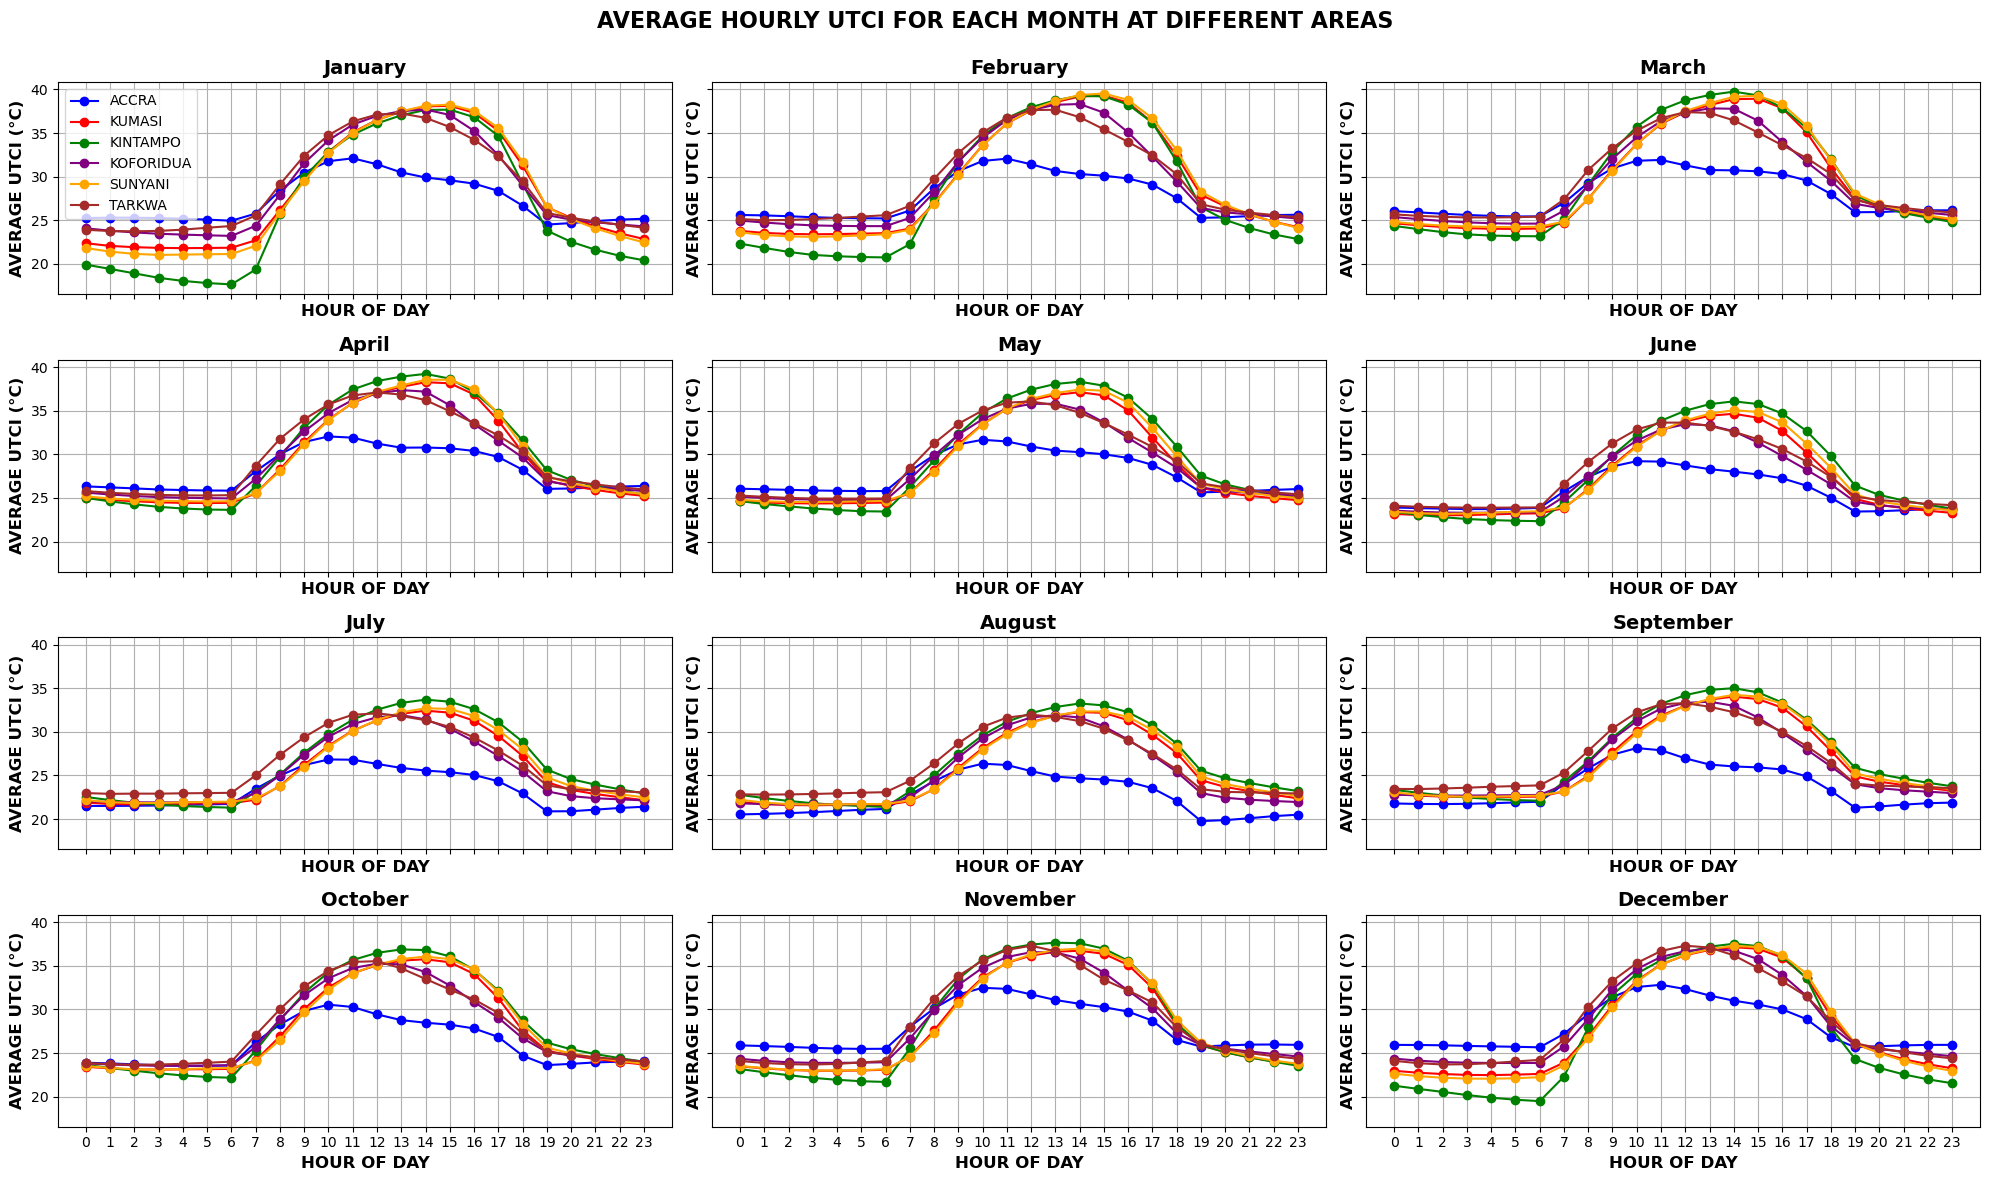

In [10]:
# Define the colors for each location
colors = {
    'ACCRA': 'blue',
    'KUMASI': 'red',
    'KINTAMPO': 'green',
    'KOFORIDUA': 'purple',
    'SUNYANI': 'orange',
    'TARKWA': 'brown'
}
def get_nearest_indices(lat, lon, latitudes, longitudes):
    lat_idx = np.argmin(np.abs(latitudes - lat))
    lon_idx = np.argmin(np.abs(longitudes - lon))
    return lat_idx, lon_idx

all_utci_df = pd.DataFrame()
latitudes = data['lat'].values
longitudes = data['lon'].values
time = data['time']

# Extract and process data for each location
for location, coords in locations.items():
    lat = coords['lat']
    lon = coords['lon']
    lat_idx, lon_idx = get_nearest_indices(lat, lon, latitudes, longitudes)
    utci_location = data['utci'][:, lat_idx, lon_idx]
    utci_location_da = xr.DataArray(utci_location, coords=[time], dims=["time"])
    utci_df = utci_location_da.to_dataframe(name='UTCI').reset_index()
    utci_df.set_index('time', inplace=True)
    utci_df['month'] = utci_df.index.month
    utci_df['hour'] = utci_df.index.hour
    utci_df['location'] = location
    all_utci_df = pd.concat([all_utci_df, utci_df])

# Calculate hourly averages for each month over all years for each location
utci_hourly_monthly_avg = all_utci_df.groupby(['location', 'month', 'hour']).mean().reset_index()

# Plotting
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

fig, axes = plt.subplots(4, 3, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, month_name in enumerate(months, start=1):
    ax = axes[i-1]
    for location, color in colors.items():
        monthly_data = utci_hourly_monthly_avg[(utci_hourly_monthly_avg['month'] == i) & 
                                               (utci_hourly_monthly_avg['location'] == location)]
        ax.plot(monthly_data['hour'], monthly_data['UTCI'], marker='o', label=location, color=color)
    ax.set_title(f'{month_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('HOUR OF DAY', fontsize=12, fontweight='bold')
    ax.set_ylabel('AVERAGE UTCI (°C)', fontsize=12, fontweight='bold')
    ax.set_xticks(np.arange(0, 24, 1))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True)
    if i == 1:  
        ax.legend()

plt.suptitle(f'AVERAGE HOURLY UTCI FOR EACH MONTH AT DIFFERENT AREAS', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(top=0.92)
#plt.savefig('HOURLY_UTCI.png')
plt.show()

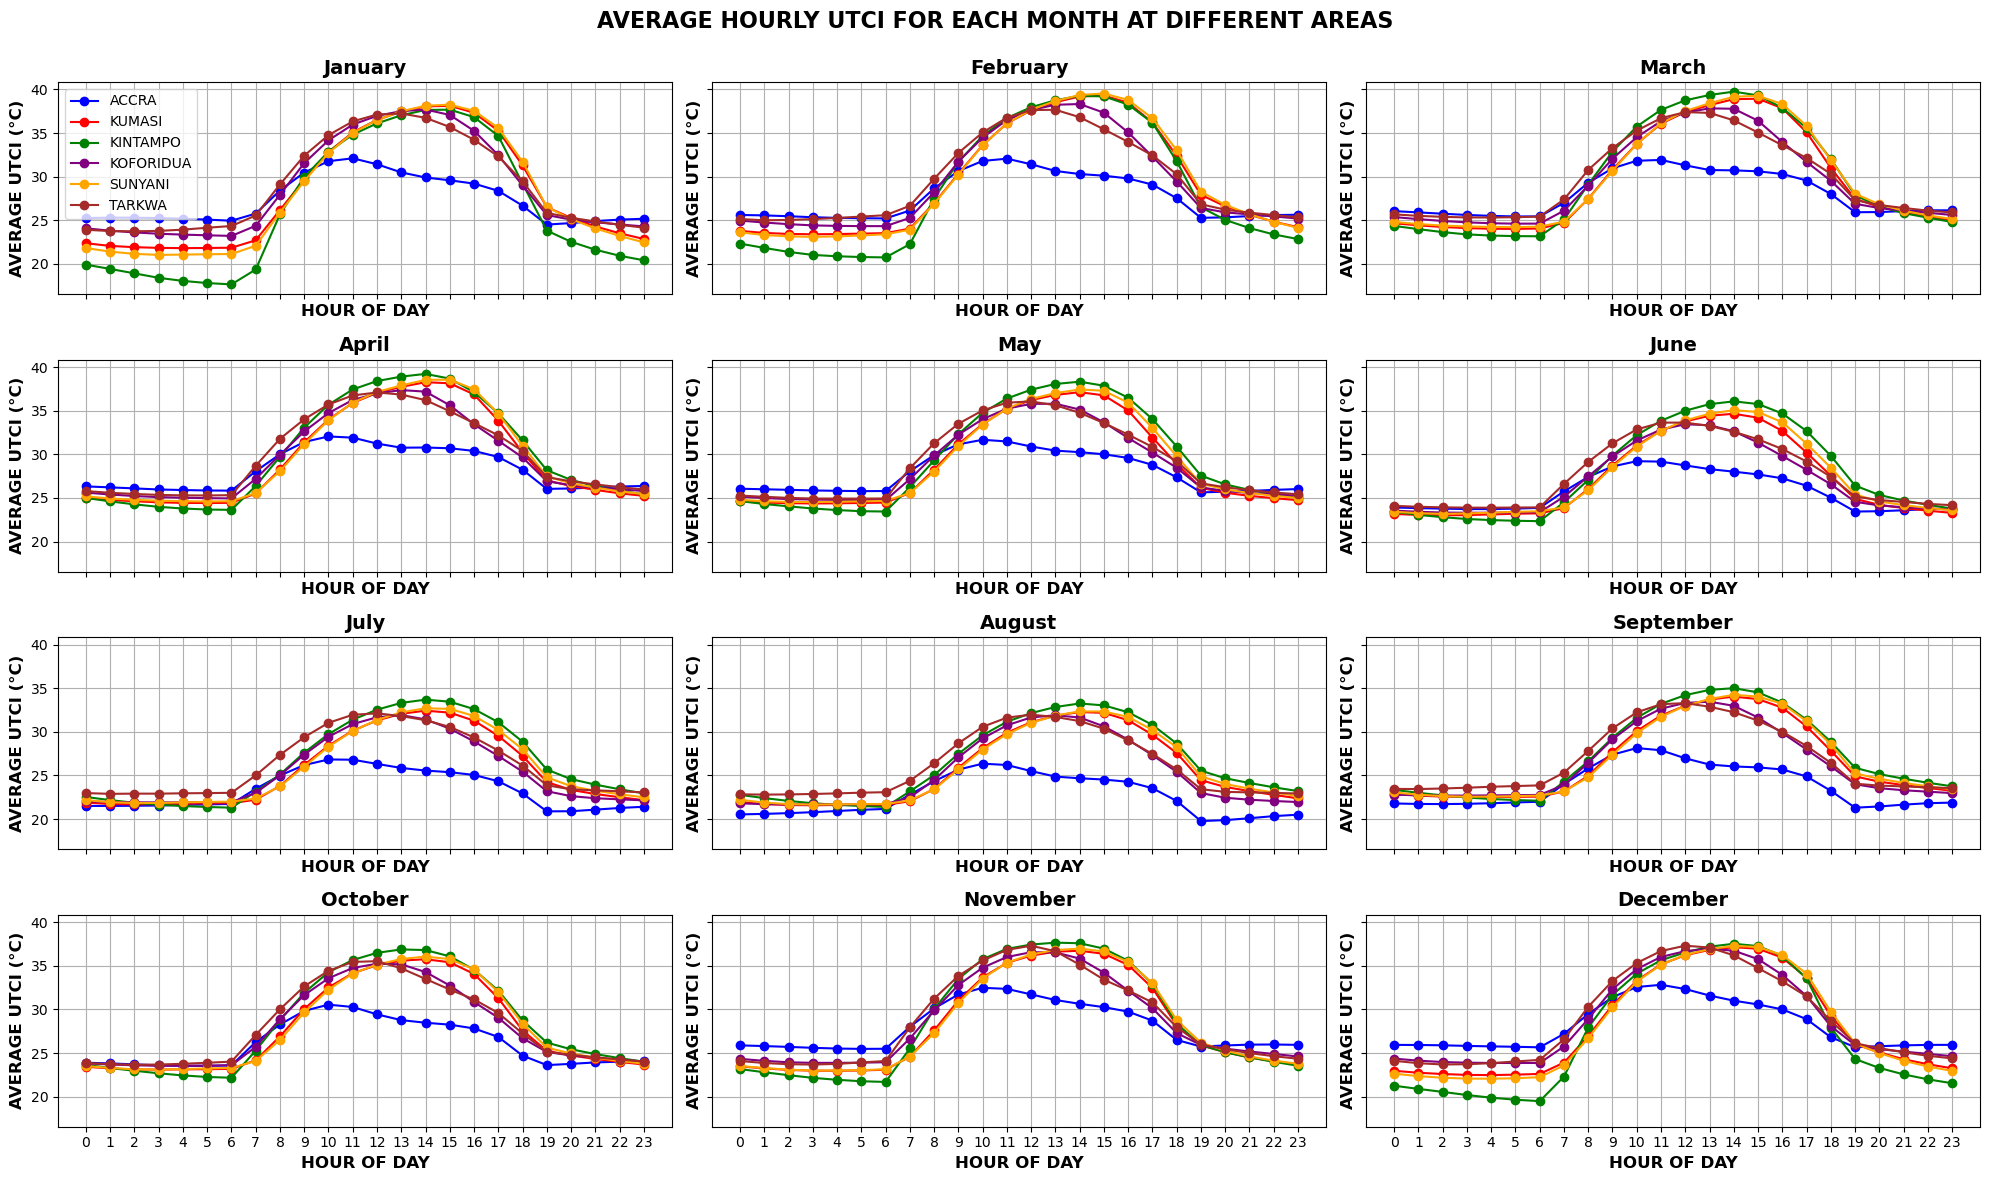

In [11]:
# Define the colors for each location
colors = {
    'ACCRA': 'blue',
    'KUMASI': 'red',
    'KINTAMPO': 'green',
    'KOFORIDUA': 'purple',
    'SUNYANI': 'orange',
    'TARKWA': 'brown'
}

def get_nearest_indices(lat, lon, latitudes, longitudes):
    lat_idx = np.argmin(np.abs(latitudes - lat))
    lon_idx = np.argmin(np.abs(longitudes - lon))
    return lat_idx, lon_idx

all_utci_df = pd.DataFrame()
latitudes = data['lat'].values
longitudes = data['lon'].values
time = data['time']

# Extract and process data for each location
for location, coords in locations.items():
    lat = coords['lat']
    lon = coords['lon']
    lat_idx, lon_idx = get_nearest_indices(lat, lon, latitudes, longitudes)
    utci_location = data['utci'][:, lat_idx, lon_idx]
    utci_location_da = xr.DataArray(utci_location, coords=[time], dims=["time"])
    utci_df = utci_location_da.to_dataframe(name='UTCI').reset_index()
    utci_df.set_index('time', inplace=True)
    utci_df['month'] = utci_df.index.month
    utci_df['hour'] = utci_df.index.hour
    utci_df['location'] = location
    all_utci_df = pd.concat([all_utci_df, utci_df])

# Calculate hourly averages for each month over all years for each location
utci_hourly_monthly_avg = all_utci_df.groupby(['location', 'month', 'hour']).mean().reset_index()

# Plotting
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

fig, axes = plt.subplots(4, 3, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, month_name in enumerate(months, start=1):
    ax = axes[i-1]
    for location, color in colors.items():
        monthly_data = utci_hourly_monthly_avg[(utci_hourly_monthly_avg['month'] == i) & 
                                               (utci_hourly_monthly_avg['location'] == location)]
        ax.plot(monthly_data['hour'], monthly_data['UTCI'], marker='o', label=location, color=color)
    ax.set_title(f'{month_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('HOUR OF DAY', fontsize=12, fontweight='bold')
    ax.set_ylabel('AVERAGE UTCI (°C)', fontsize=12, fontweight='bold')
    ax.set_xticks(np.arange(0, 24, 1))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True)
    if i == 1:  
        ax.legend()

plt.suptitle(f'AVERAGE HOURLY UTCI FOR EACH MONTH AT DIFFERENT AREAS', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(top=0.92)
# plt.savefig('HOURLY_UTCI.png')
plt.show()

# ANNUAL SCATTER PLOTS 

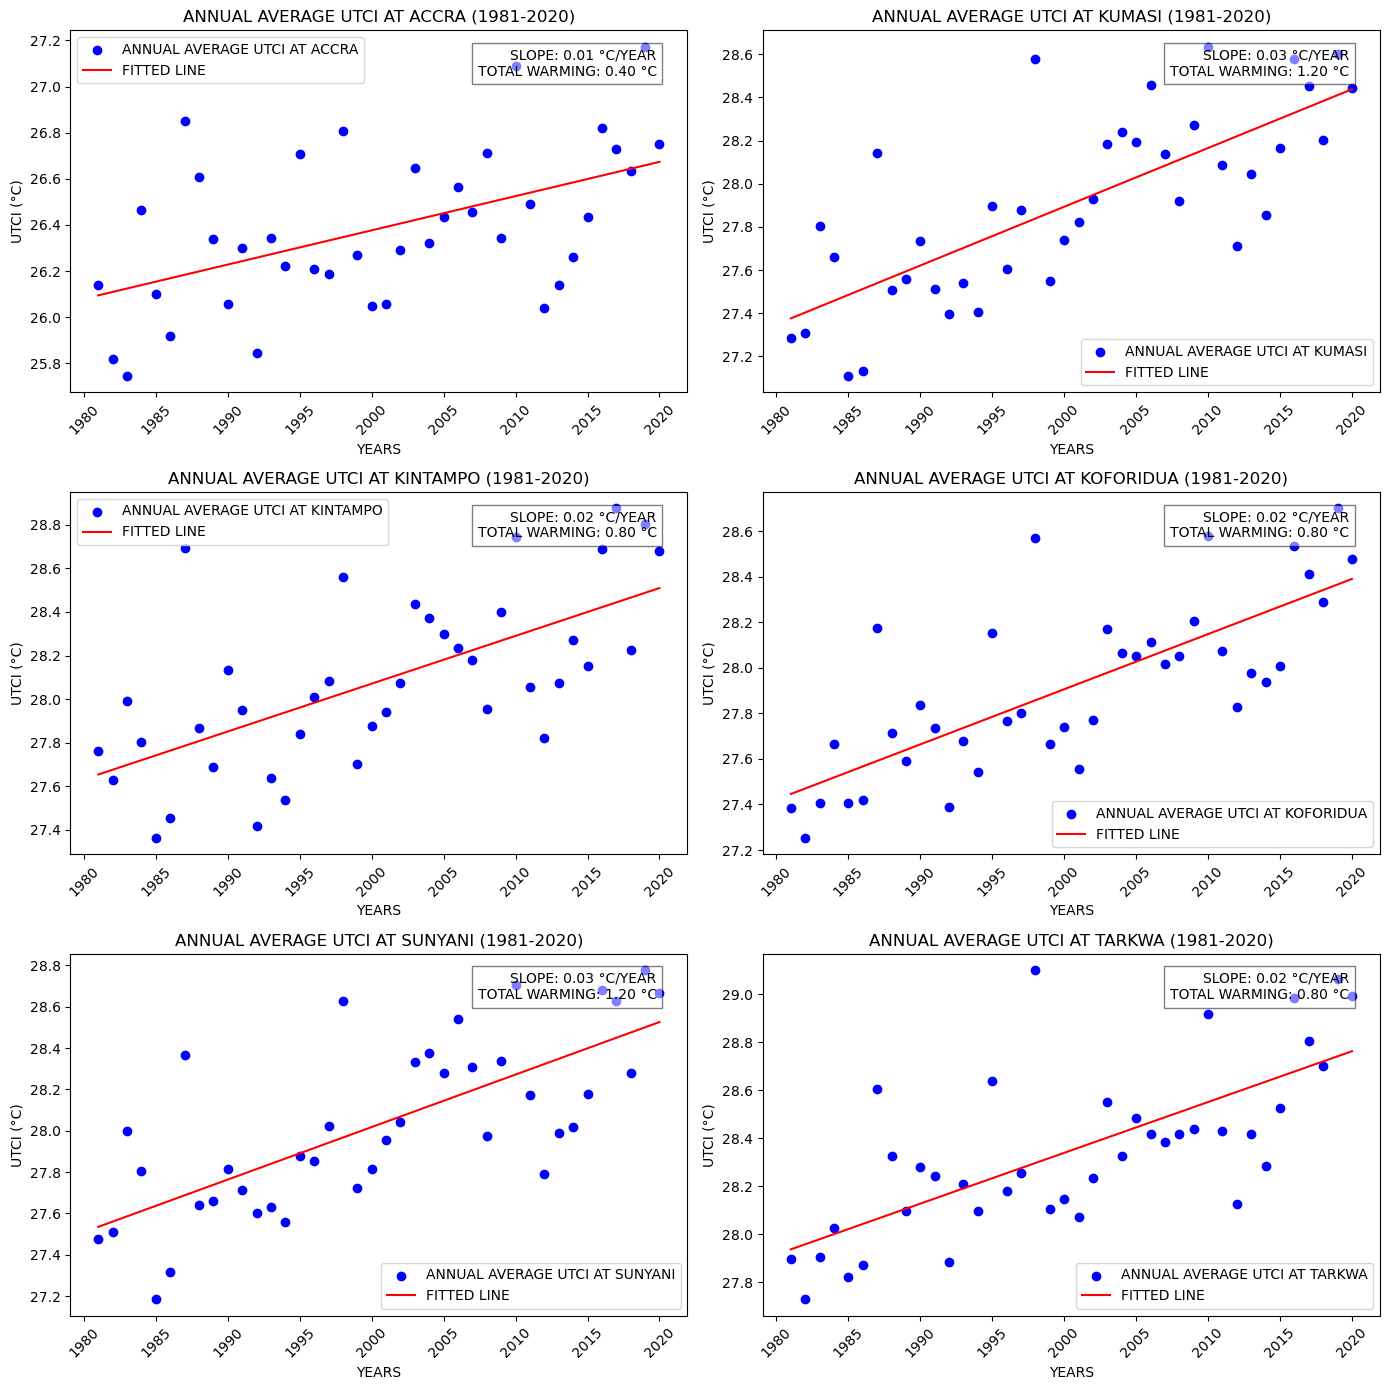

In [12]:
total_warming_values = {
    'KUMASI': 0.03 * 40,
    'ACCRA': 0.01 * 40,
    'KINTAMPO': 0.02 * 40,
    'SUNYANI': 0.03 * 40,
    'TARKWA': 0.02 * 40,
    'KOFORIDUA': 0.02 * 40
}

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))
axs = axs.flatten()

for i, (location, coords) in enumerate(locations.items()):
    utci_location = data['utci'].sel(lat=coords['lat'], lon=coords['lon'], method='nearest')
    time = data['time']
    mask = (time.dt.year >= 1981) & (time.dt.year <= 2020)
    utci_location = utci_location.where(mask, drop=True)
    utci_location_annual = utci_location.resample(time='1Y').mean()
    years_location = utci_location_annual['time.year']
    
    slope_location, intercept_location, r_value_location, p_value_location, std_err_location = linregress(years_location, utci_location_annual)
    
    total_warming = total_warming_values[location]
    
    axs[i].scatter(years_location, utci_location_annual, c='blue', label=f'ANNUAL AVERAGE UTCI AT {location.upper()}')
    axs[i].plot(years_location, intercept_location + slope_location * years_location, 'r', label='FITTED LINE')
    axs[i].set_xlabel('YEARS')
    axs[i].set_ylabel('UTCI (°C)')
    axs[i].set_title(f'ANNUAL AVERAGE UTCI AT {location.upper()} (1981-2020)')
    axs[i].text(0.95, 0.95, f'SLOPE: {slope_location:.2f} °C/YEAR\nTOTAL WARMING: {total_warming:.2f} °C', transform=axs[i].transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
    axs[i].set_xticks(years_location)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[i].legend()

plt.tight_layout()
#plt.savefig('SCATTER_PLOT.png')
plt.show()

# ALTERNATIVES 

In [13]:
# Updated coordinates for each location
locations = {
    'NAVRONGO': {'lat': 10.891, 'lon': -1.070},
    'YENDI': {'lat': 9.443, 'lon': -0.029},
    'KINTAMPO': {'lat': 8.056, 'lon': -1.730},
    'KUMASI': {'lat': 6.693, 'lon': -1.622},
    'ACCRA': {'lat': 5.6037, 'lon': -0.187},
    'TARKWA': {'lat': 5.3076, 'lon': -1.9847},
}

# Colors for each location
colors = {
    'NAVRONGO': 'green',
    'YENDI': 'red',
    'KINTAMPO': 'orange',
    'KUMASI': 'blue',
    'ACCRA': 'purple',
    'TARKWA': 'brown'
}

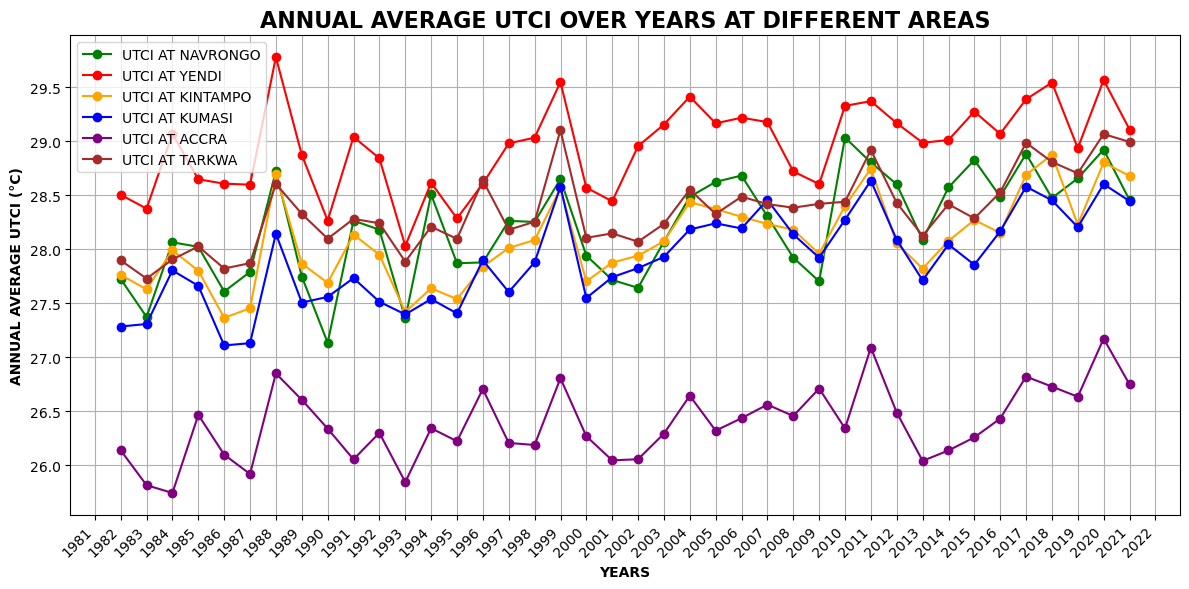

In [14]:
plt.figure(figsize=(12, 6))

for location, coords in locations.items():
    latitudes = data['lat'].values.astype(np.float64)
    longitudes = data['lon'].values.astype(np.float64)
    lat_idx = np.argmin(np.abs(latitudes - coords['lat']))
    lon_idx = np.argmin(np.abs(longitudes - coords['lon']))

    utci_location = data['utci'][:, lat_idx, lon_idx]
    utci_annual = utci_location.resample(time='Y').mean(dim='time')

    plt.plot(utci_annual['time'], utci_annual, marker='o', color=colors[location], label=f'UTCI AT {location.upper()}')


ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, ha='right')
plt.xlabel('YEARS', fontweight='bold')
plt.ylabel('ANNUAL AVERAGE UTCI (°C)', fontweight='bold')
plt.title('ANNUAL AVERAGE UTCI OVER YEARS AT DIFFERENT AREAS', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig('ANNUAL_AVERAGE_UTCI(1).png')
plt.show()

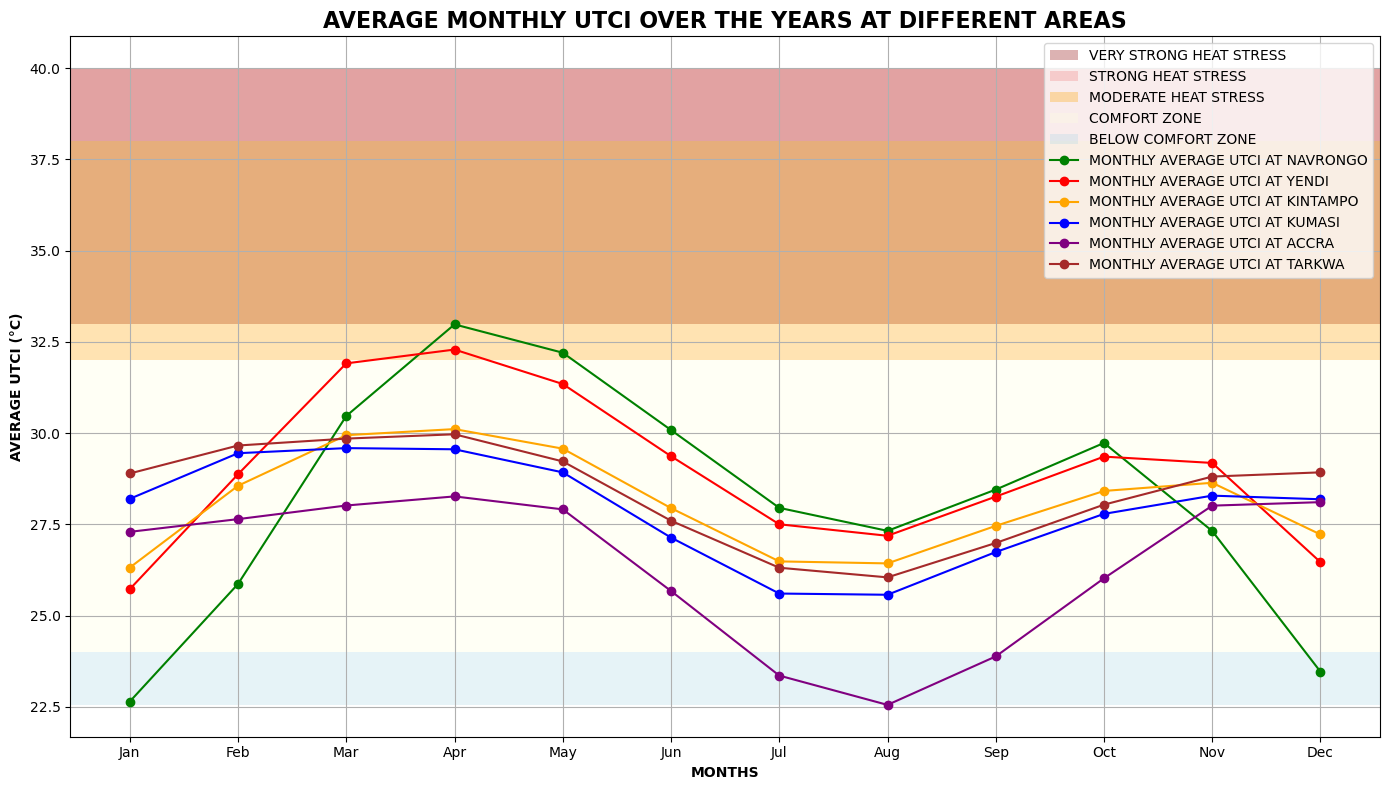

In [15]:
utci_monthly_avg = {}
for location, coords in locations.items():
    lat = coords['lat']
    lon = coords['lon']
    
    latitudes = data['lat'].values.astype(np.float64)
    longitudes = data['lon'].values.astype(np.float64)
    lat_idx = np.argmin(np.abs(latitudes - lat))
    lon_idx = np.argmin(np.abs(longitudes - lon))
    utci_location = data['utci'][:, lat_idx, lon_idx]

    utci_location_da = xr.DataArray(utci_location, coords=[data.time], dims=["time"])
    utci_monthly_location = utci_location_da.resample(time='M').mean()

    utci_monthly_avg_location = utci_monthly_location.groupby(utci_monthly_location.time.dt.month).mean()
    utci_monthly_avg[location] = utci_monthly_avg_location


months = np.arange(1, 13)
month_names = [calendar.month_abbr[m] for m in months]

# Define ranges for UTCI levels and corresponding face colors
comfort_zone_threshold = 24  # Comfort zone
moderate_heat_stress_threshold = 32  # Moderate heat stress
strong_heat_stress_threshold = 38  # Strong heat stress
very_strong_heat_stress_threshold = 40  # Very strong heat stress (Heat stroke)



fig, ax = plt.subplots(figsize=(14, 8))
# Add background colors for thresholds
ax.axhspan(very_strong_heat_stress_threshold, max([utci_monthly_avg[loc].max() for loc in locations]), facecolor='darkred', alpha=0.3, label='VERY STRONG HEAT STRESS')
ax.axhspan(strong_heat_stress_threshold, very_strong_heat_stress_threshold, facecolor='lightcoral', alpha=0.3, label='STRONG HEAT STRESS')
ax.axhspan(moderate_heat_stress_threshold, strong_heat_stress_threshold, facecolor='orange', alpha=0.3, label='MODERATE HEAT STRESS')
ax.axhspan(comfort_zone_threshold, moderate_heat_stress_threshold, facecolor='lightyellow', alpha=0.3, label='COMFORT ZONE')
ax.axhspan(min([utci_monthly_avg[loc].min() for loc in locations]), comfort_zone_threshold, facecolor='lightblue', alpha=0.3, label='BELOW COMFORT ZONE')

# Plot the monthly average UTCI for each location
for location, color in colors.items():
    ax.plot(months, utci_monthly_avg[location], marker='o', color=color, label=f'MONTHLY AVERAGE UTCI AT {location.upper()}')

# Format the x-axis
ax.set_xticks(months)
ax.set_xticklabels(month_names)
ax.set_xlabel('MONTHS', fontweight='bold')
ax.set_ylabel('AVERAGE UTCI (°C)', fontweight='bold')
ax.set_title('AVERAGE MONTHLY UTCI OVER THE YEARS AT DIFFERENT AREAS', fontsize=16, fontweight='bold')
ax.legend()
ax.grid(True)
plt.tight_layout()
#plt.savefig('AVERAGE_MONTHLY_UTCI(1).png')
plt.show()

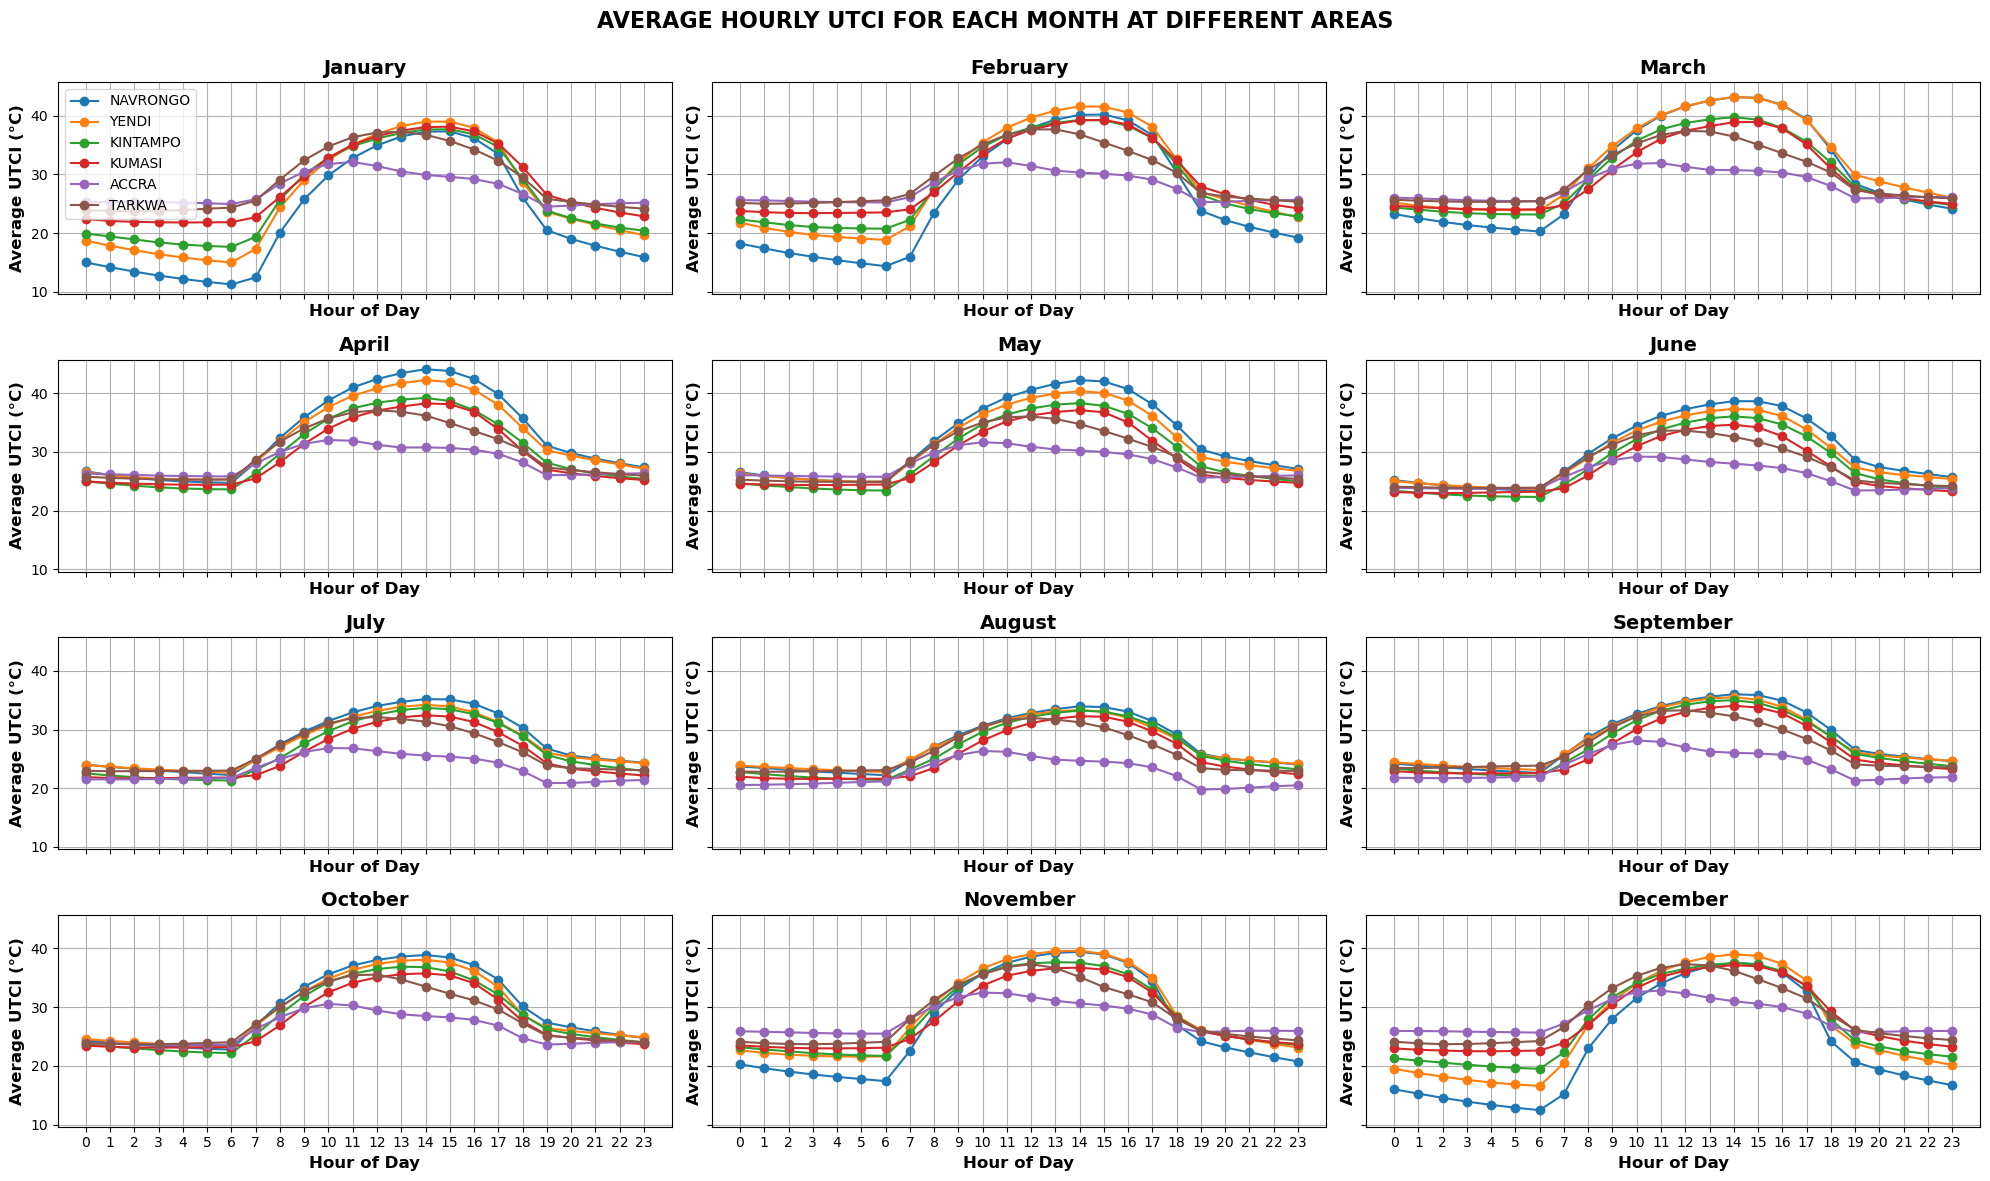

In [16]:
# Colors for each location
colors = {
    'NAVRONGO': 'green',
    'YENDI': 'red',
    'KINTAMPO': 'orange',
    'KUMASI': 'blue',
    'ACCRA': 'purple',
    'TARKWA': 'brown'
}

def get_nearest_indices(lat, lon, latitudes, longitudes):
    lat_idx = np.argmin(np.abs(latitudes - lat))
    lon_idx = np.argmin(np.abs(longitudes - lon))
    return lat_idx, lon_idx

# Prepare a DataFrame to store all location data
all_utci_df = pd.DataFrame()

# Convert latitude and longitude to numpy arrays
latitudes = data['lat'].values
longitudes = data['lon'].values
time = data['time']

# Extract and process data for each location
for location, coords in locations.items():
    lat = coords['lat']
    lon = coords['lon']
    lat_idx, lon_idx = get_nearest_indices(lat, lon, latitudes, longitudes)
    utci_location = data['utci'][:, lat_idx, lon_idx]
    utci_location_da = xr.DataArray(utci_location, coords=[time], dims=["time"])
    utci_df = utci_location_da.to_dataframe(name='UTCI').reset_index()
    utci_df.set_index('time', inplace=True)
    utci_df['month'] = utci_df.index.month
    utci_df['hour'] = utci_df.index.hour
    utci_df['location'] = location
    all_utci_df = pd.concat([all_utci_df, utci_df])

# Calculate hourly averages for each month over all years for each location
utci_hourly_monthly_avg = all_utci_df.groupby(['location', 'month', 'hour']).mean().reset_index()

# Plotting
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

fig, axes = plt.subplots(4, 3, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, month_name in enumerate(months, start=1):
    ax = axes[i-1]
    for location in locations.keys():
        monthly_data = utci_hourly_monthly_avg[(utci_hourly_monthly_avg['month'] == i) & 
                                               (utci_hourly_monthly_avg['location'] == location)]
        ax.plot(monthly_data['hour'], monthly_data['UTCI'], marker='o', label=location)
    ax.set_title(f'{month_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average UTCI (°C)', fontsize=12, fontweight='bold')
    ax.set_xticks(np.arange(0, 24, 1))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True)
    if i == 1:  # Only add legend to the first subplot for clarity
        ax.legend()

plt.suptitle(f'AVERAGE HOURLY UTCI FOR EACH MONTH AT DIFFERENT AREAS', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(top=0.92)
#plt.savefig('HOURLY_UTCI(1).png')
plt.show()

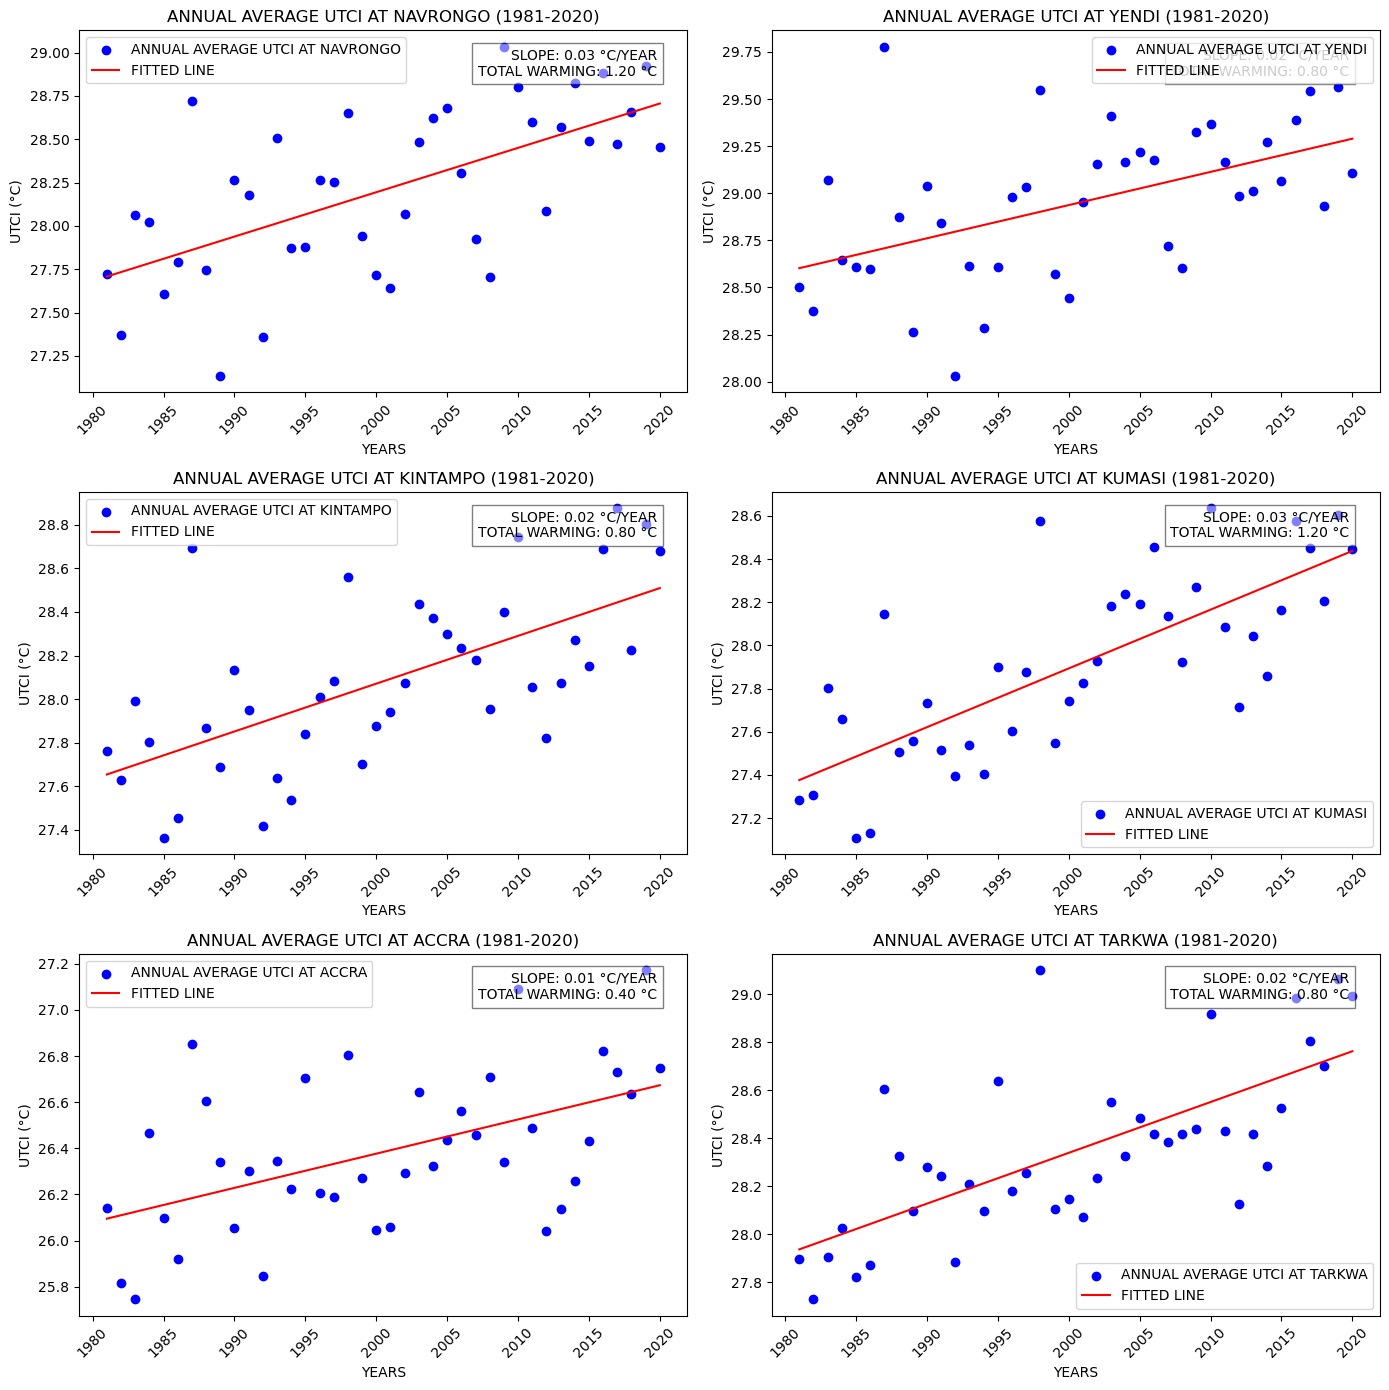

In [17]:
# Define coordinates for each location
locations = {
    'NAVRONGO': {'lat': 10.891, 'lon': -1.070},
    'YENDI': {'lat': 9.433, 'lon': -0.017},
    'KINTAMPO': {'lat': 8.056, 'lon': -1.730},
    'KUMASI': {'lat': 6.693, 'lon': -1.622},
    'ACCRA': {'lat': 5.6037, 'lon': -0.187},
    'TARKWA': {'lat': 5.3076, 'lon': -1.9847},
}


# Total warming values provided
total_warming_values = {
    'KUMASI': 0.03 * 40,
    'ACCRA': 0.01 * 40,
    'KINTAMPO': 0.02 * 40,
    'NAVRONGO': 0.03 * 40,
    'YENDI': 0.02 * 40,
    'TARKWA': 0.02 * 40
}

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))
axs = axs.flatten()

for i, (location, coords) in enumerate(locations.items()):
    utci_location = data['utci'].sel(lat=coords['lat'], lon=coords['lon'], method='nearest')
    time = data['time']
    mask = (time.dt.year >= 1981) & (time.dt.year <= 2020)
    utci_location = utci_location.where(mask, drop=True)
    utci_location_annual = utci_location.resample(time='1Y').mean()
    years_location = utci_location_annual['time.year']
    
    slope_location, intercept_location, r_value_location, p_value_location, std_err_location = linregress(years_location, utci_location_annual)
    
    total_warming = total_warming_values[location]
    
    axs[i].scatter(years_location, utci_location_annual, c='blue', label=f'ANNUAL AVERAGE UTCI AT {location.upper()}')
    axs[i].plot(years_location, intercept_location + slope_location * years_location, 'r', label='FITTED LINE')
    axs[i].set_xlabel('YEARS')
    axs[i].set_ylabel('UTCI (°C)')
    axs[i].set_title(f'ANNUAL AVERAGE UTCI AT {location.upper()} (1981-2020)')
    axs[i].text(0.95, 0.95, f'SLOPE: {slope_location:.2f} °C/YEAR\nTOTAL WARMING: {total_warming:.2f} °C', transform=axs[i].transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
    axs[i].set_xticks(years_location)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[i].legend()

plt.tight_layout()
#plt.savefig('SCATTER_PLOT(1).png')
plt.show()


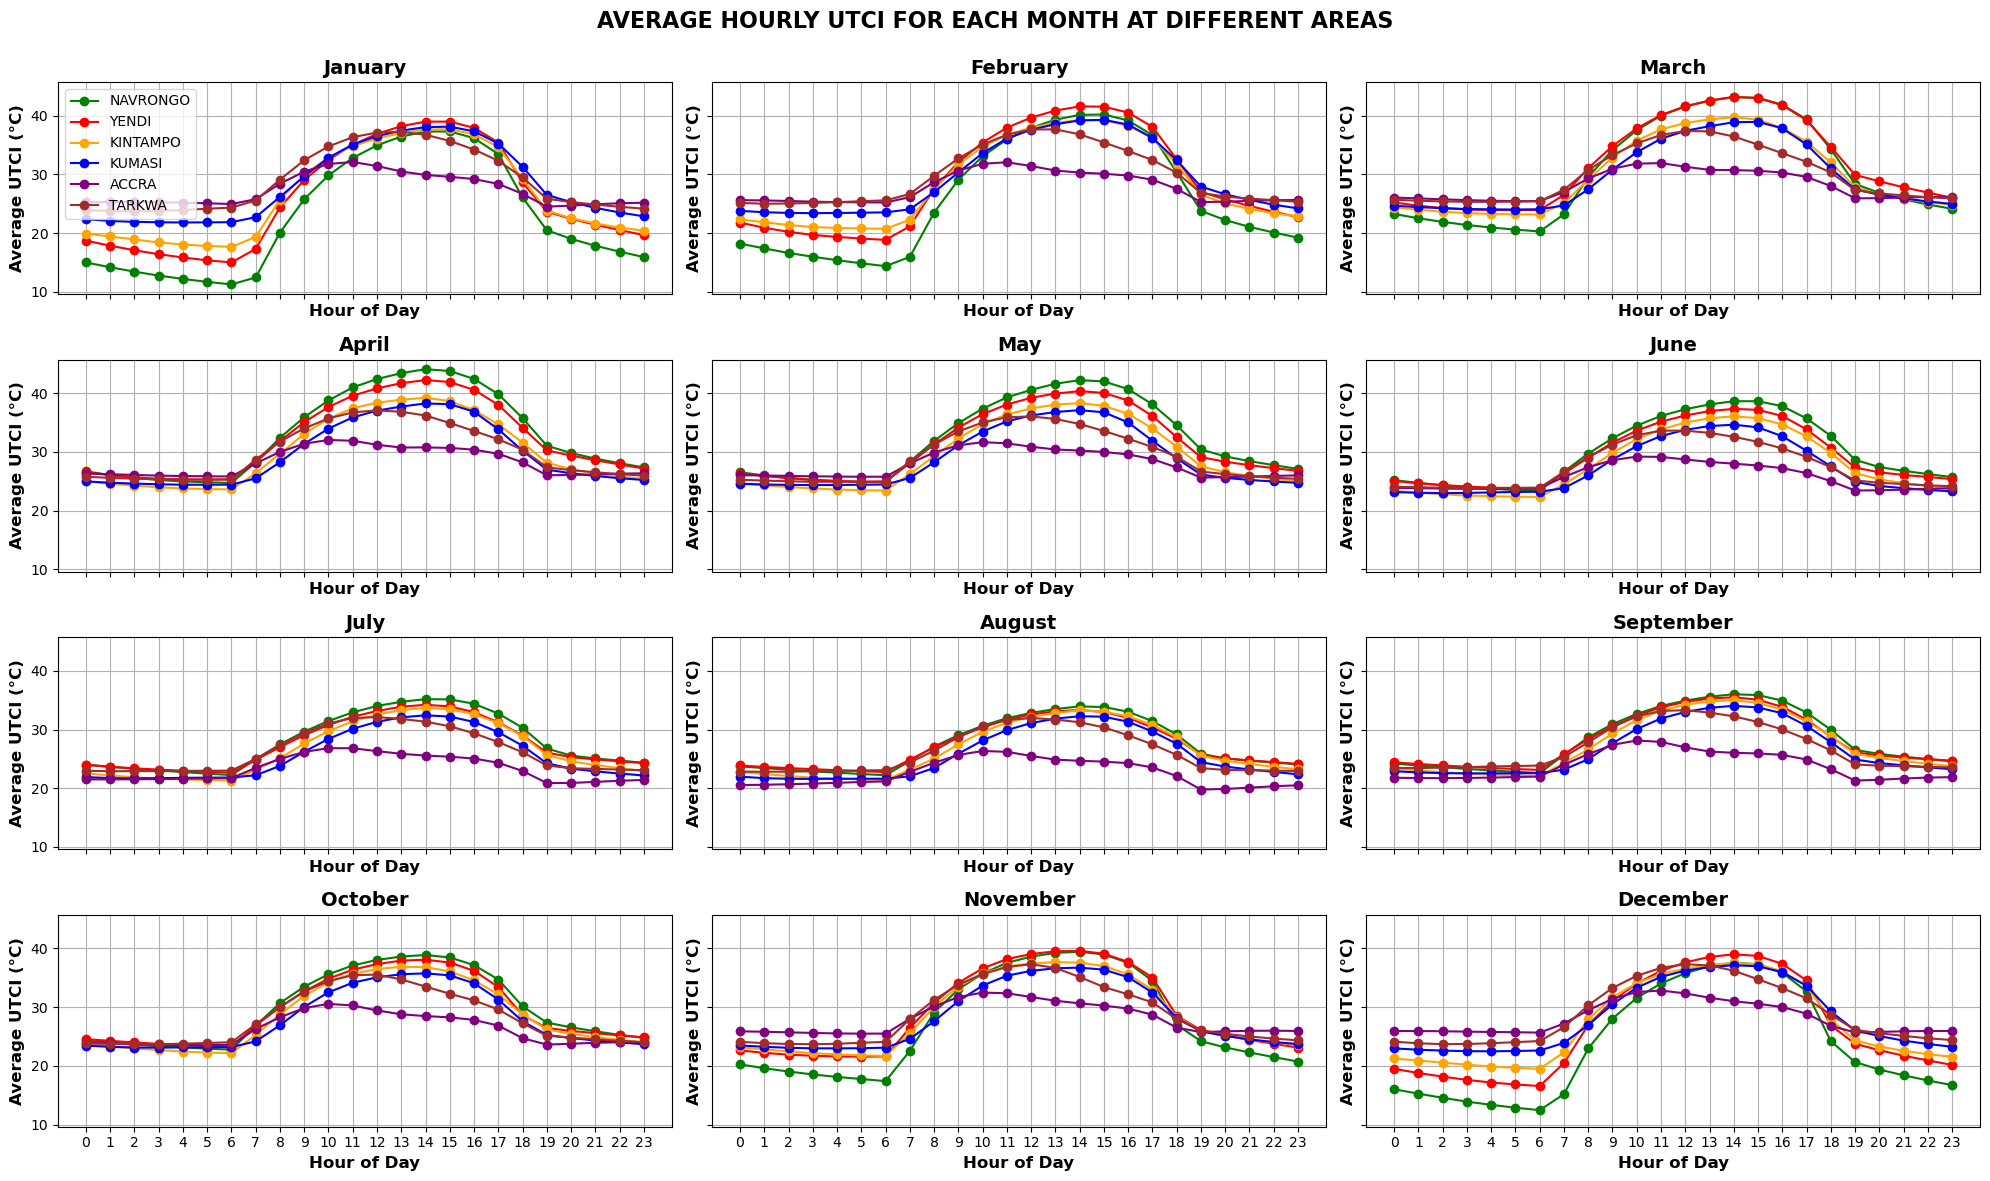

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Assuming 'data' is already loaded and contains the necessary variables

# Colors for each location
colors = {
    'NAVRONGO': 'green',
    'YENDI': 'red',
    'KINTAMPO': 'orange',
    'KUMASI': 'blue',
    'ACCRA': 'purple',
    'TARKWA': 'brown'
}

def get_nearest_indices(lat, lon, latitudes, longitudes):
    lat_idx = np.argmin(np.abs(latitudes - lat))
    lon_idx = np.argmin(np.abs(longitudes - lon))
    return lat_idx, lon_idx

# Prepare a DataFrame to store all location data
all_utci_df = pd.DataFrame()

# Convert latitude and longitude to numpy arrays
latitudes = data['lat'].values
longitudes = data['lon'].values
time = data['time']

# Extract and process data for each location
for location, coords in locations.items():
    lat = coords['lat']
    lon = coords['lon']
    lat_idx, lon_idx = get_nearest_indices(lat, lon, latitudes, longitudes)
    utci_location = data['utci'][:, lat_idx, lon_idx]
    utci_location_da = xr.DataArray(utci_location, coords=[time], dims=["time"])
    utci_df = utci_location_da.to_dataframe(name='UTCI').reset_index()
    utci_df.set_index('time', inplace=True)
    utci_df['month'] = utci_df.index.month
    utci_df['hour'] = utci_df.index.hour
    utci_df['location'] = location
    all_utci_df = pd.concat([all_utci_df, utci_df])

# Calculate hourly averages for each month over all years for each location
utci_hourly_monthly_avg = all_utci_df.groupby(['location', 'month', 'hour']).mean().reset_index()

# Plotting
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

fig, axes = plt.subplots(4, 3, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, month_name in enumerate(months, start=1):
    ax = axes[i-1]
    for location in locations.keys():
        monthly_data = utci_hourly_monthly_avg[(utci_hourly_monthly_avg['month'] == i) & 
                                               (utci_hourly_monthly_avg['location'] == location)]
        ax.plot(monthly_data['hour'], monthly_data['UTCI'], marker='o', label=location, color=colors[location])
    ax.set_title(f'{month_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average UTCI (°C)', fontsize=12, fontweight='bold')
    ax.set_xticks(np.arange(0, 24, 1))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True)
    if i == 1:  # Only add legend to the first subplot for clarity
        ax.legend()

plt.suptitle('AVERAGE HOURLY UTCI FOR EACH MONTH AT DIFFERENT AREAS', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(top=0.92)
#plt.savefig('HOURLY_UTCI.png', dpi=300)
plt.show()


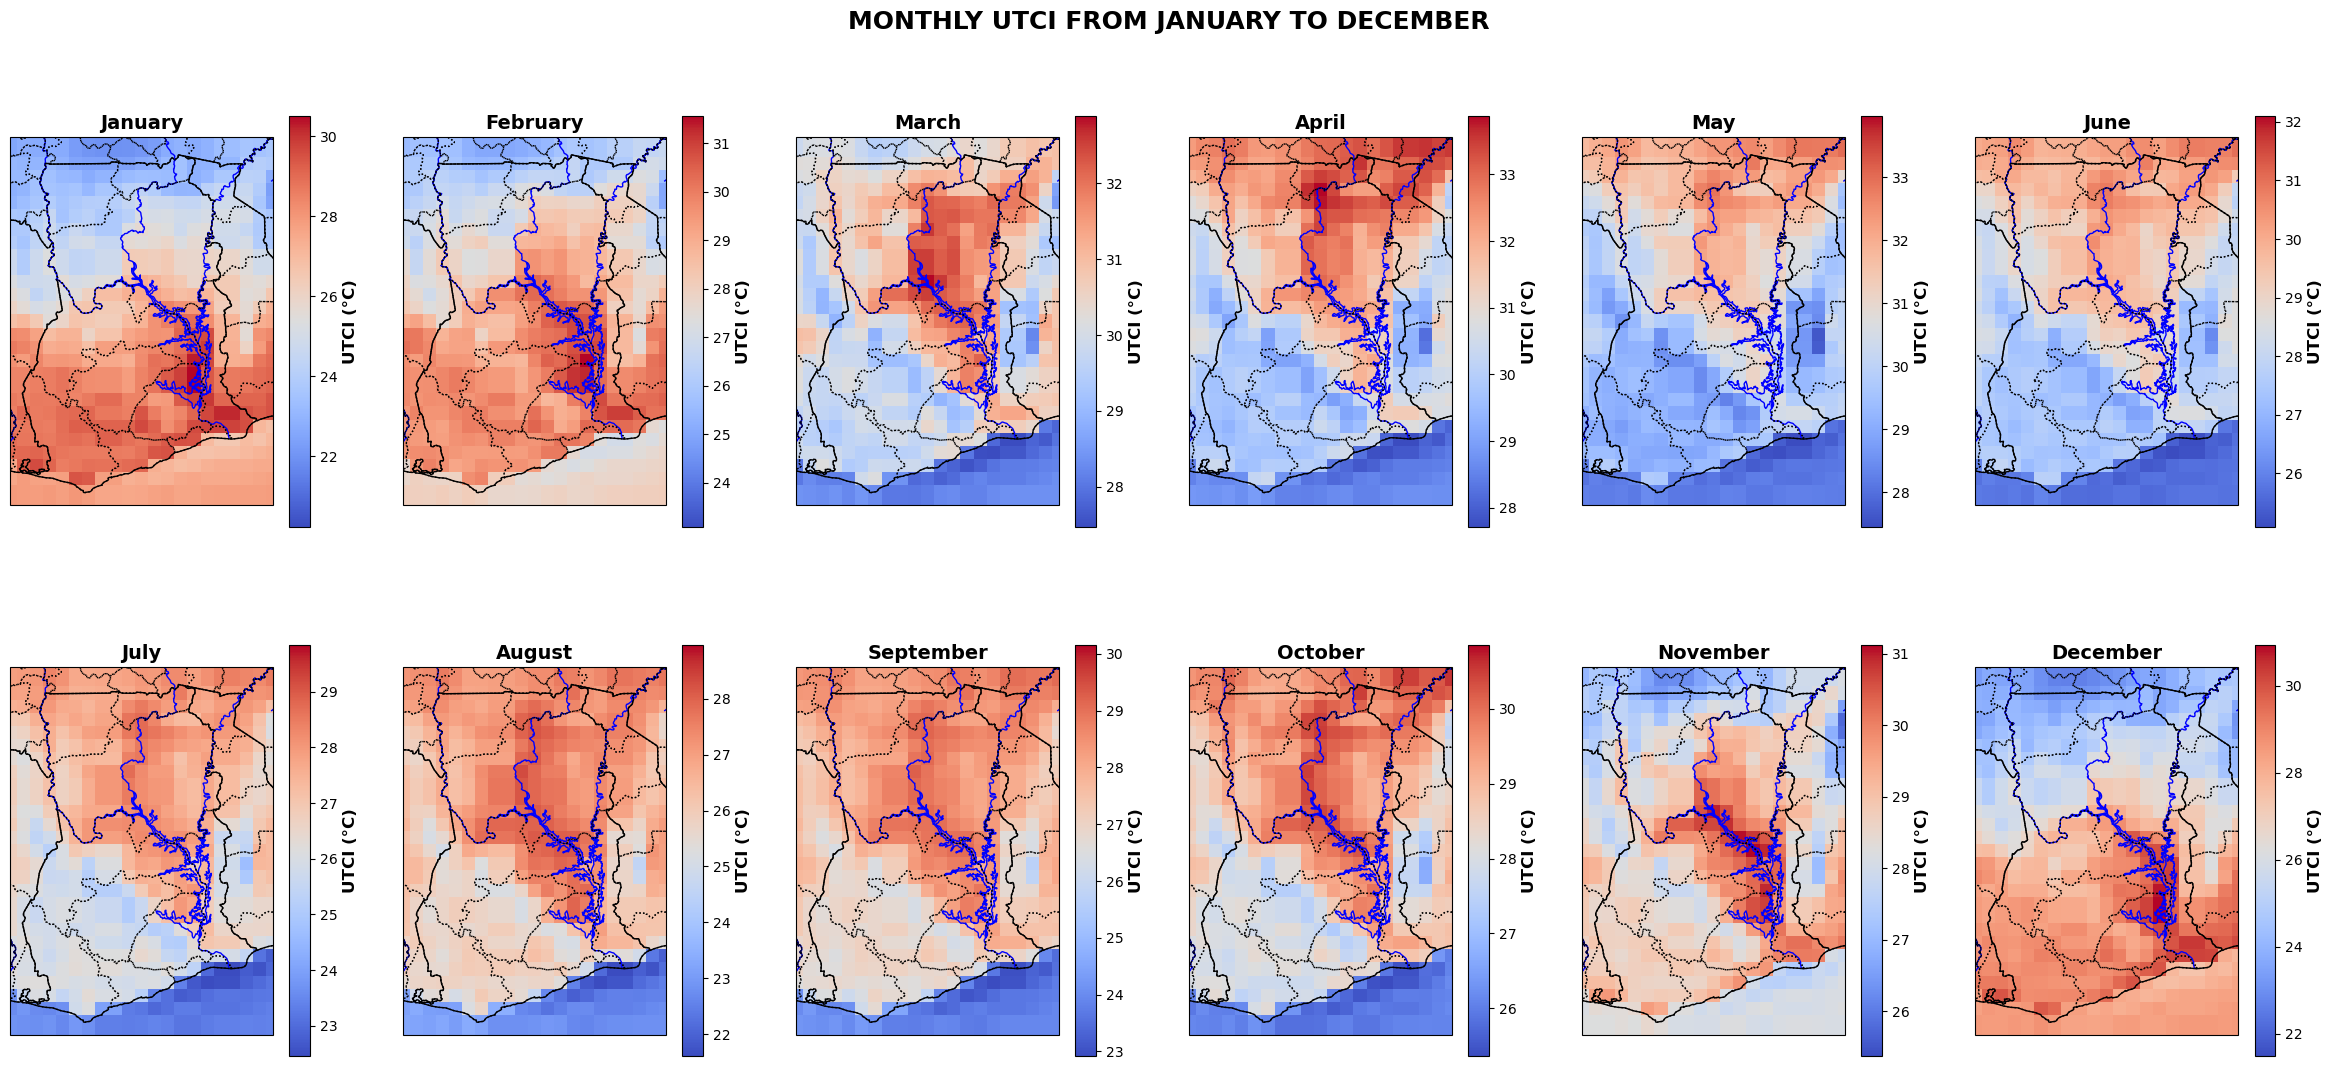

In [19]:
# Define dry and rainy season months
dry_season_months = [1, 2, 3, 11, 12]  # January to March, November, December
rainy_season_months = [4, 5, 6, 7, 8, 9, 10]  # April to October

def get_month_name(month):
    """Returns the correct month name given a month number."""
    return calendar.month_name[month]

def get_month_data(data, month):
    """Return data for a specific month, averaged over available years."""
    data_month = data.sel(time=data['time.month'] == month)
    if len(data_month['time']) > 0:
        return data_month.mean(dim='time')
    else:
        return None

def plot_utci(ax, data, month_name):
    """Plots UTCI data on the given axis with default colormap settings."""
    ax.set_extent([-3.5, 1.5, 4.5, 11.5], crs=ccrs.PlateCarree())

    # Add map features
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.RIVERS, linestyle='-', edgecolor='blue')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='none')
    ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black')
    ax.add_feature(cfeature.OCEAN)

    # Plot data
    p = ax.pcolormesh(data['lon'], data['lat'], data['utci'], transform=ccrs.PlateCarree(), cmap='coolwarm', shading='auto')
    cbar = plt.colorbar(p, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
    cbar.set_label('UTCI (°C)', fontsize=12, fontweight='bold')

    ax.set_title(f"{month_name}", fontsize=14, fontweight='bold')

# Set the figure size for better visibility
fig, axes = plt.subplots(nrows=2, ncols=6, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(24, 12))

axes = axes.flatten()

# Define a list of all months to plot in order
all_months = list(range(1, 13))  # January to December

# Plot for each month
for i, month in enumerate(all_months):
    ax = axes[i]
    month_data = get_month_data(data, month)
    if month_data is not None:
        month_name = get_month_name(month)
        plot_utci(ax, month_data, month_name)

# Turn off any empty subplots
for ax in axes[len(all_months):]:
    ax.axis('off')

# Adjust layout and show plots
fig.tight_layout(pad=3.0)
fig.suptitle('MONTHLY UTCI FROM JANUARY TO DECEMBER', fontsize=18, fontweight='bold')
plt.show()

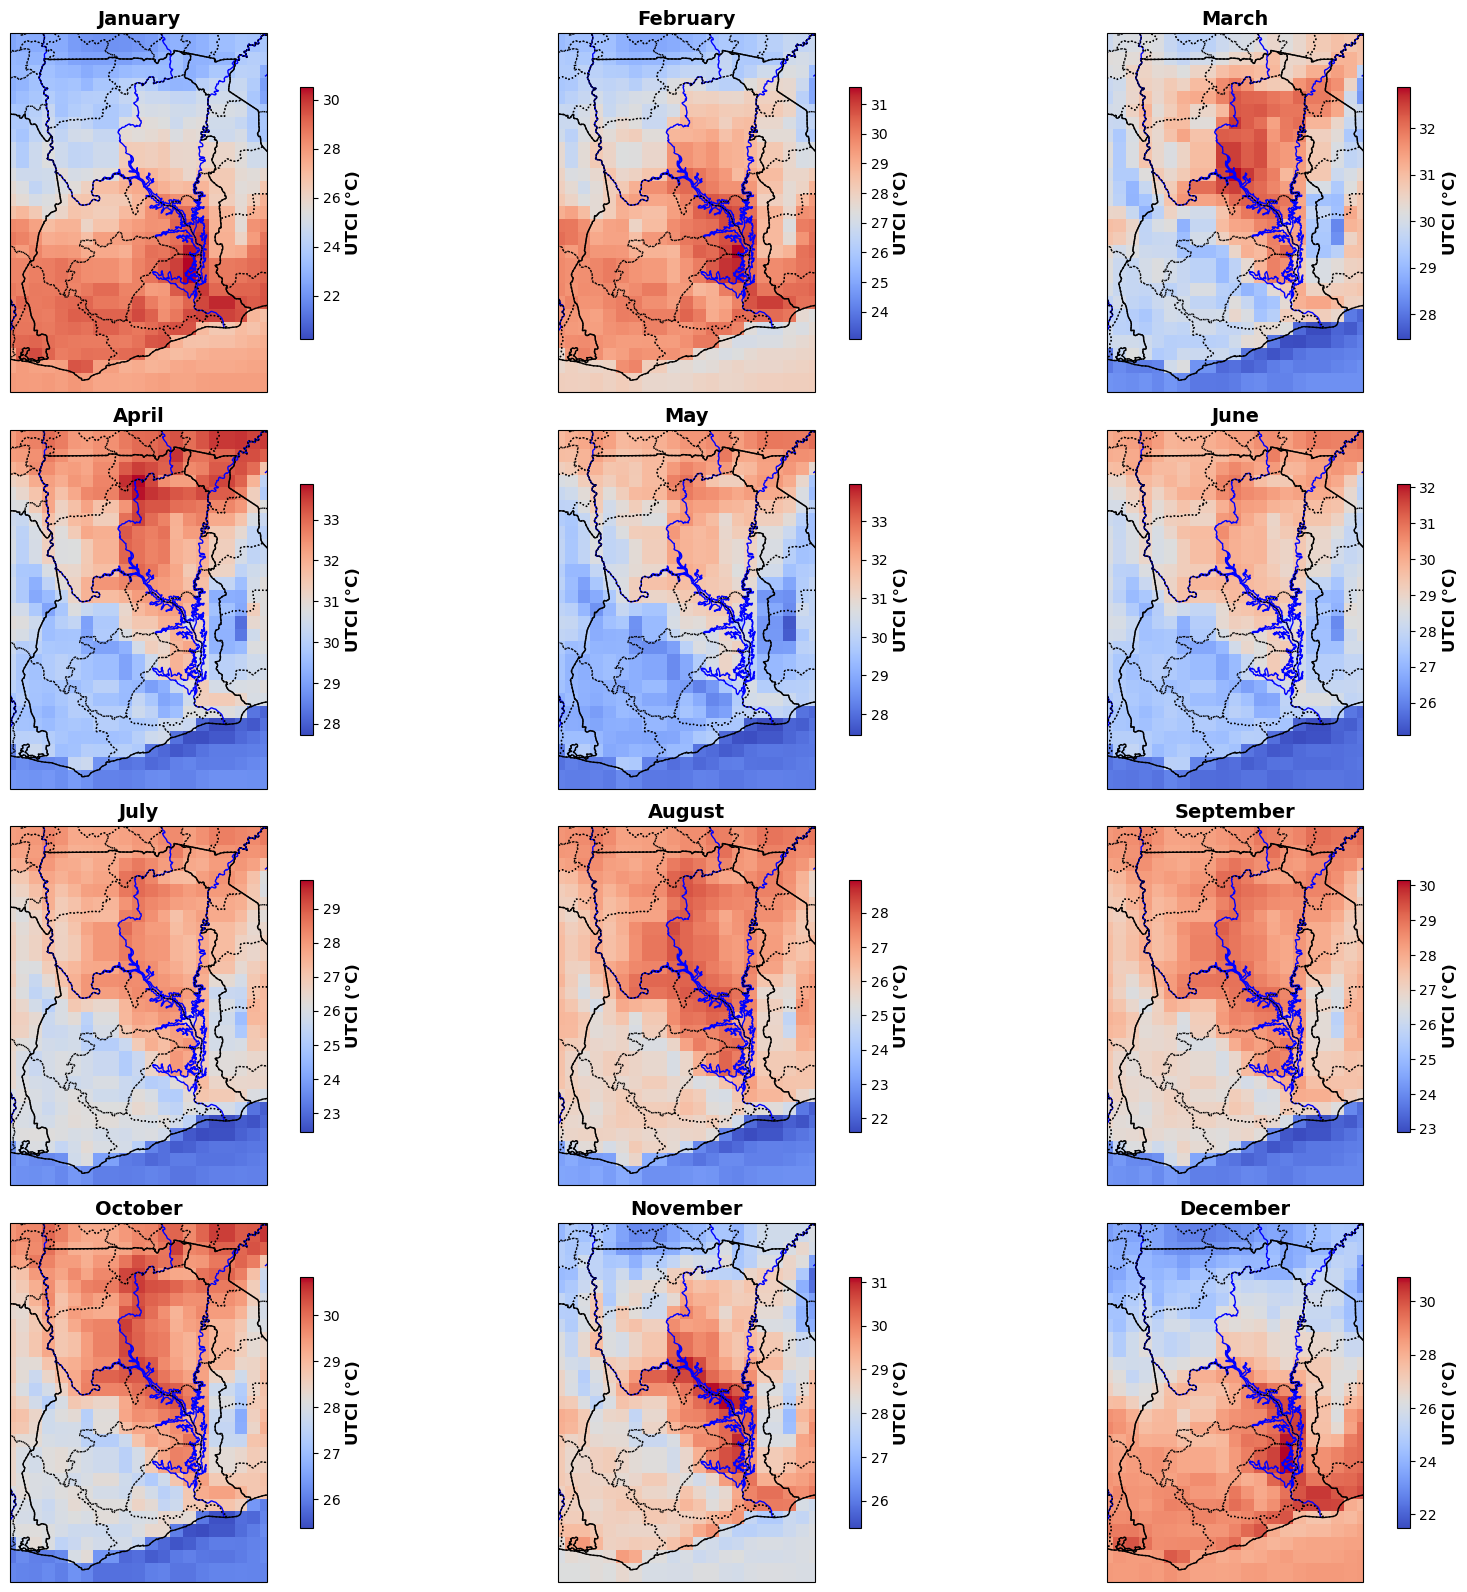

In [25]:
# Set the figure size and layout for 4 rows and 3 columns
fig, axes = plt.subplots(nrows=4, ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(18, 16))

axes = axes.flatten()

# Define a list of all months to plot in order
all_months = list(range(1, 13))  # January to December

# Plot for each month
for i, month in enumerate(all_months):
    ax = axes[i]
    month_data = get_month_data(data, month)
    if month_data is not None:
        month_name = get_month_name(month)
        plot_utci(ax, month_data, month_name)

# Turn off any empty subplots (if there are any)
for ax in axes[len(all_months):]:
    ax.axis('off')

# Adjust layout and show plots
fig.tight_layout(pad=1.0)
#fig.suptitle('MONTHLY UTCI FROM JANUARY TO DECEMBER', fontsize=10, fontweight='bold')
plt.show()

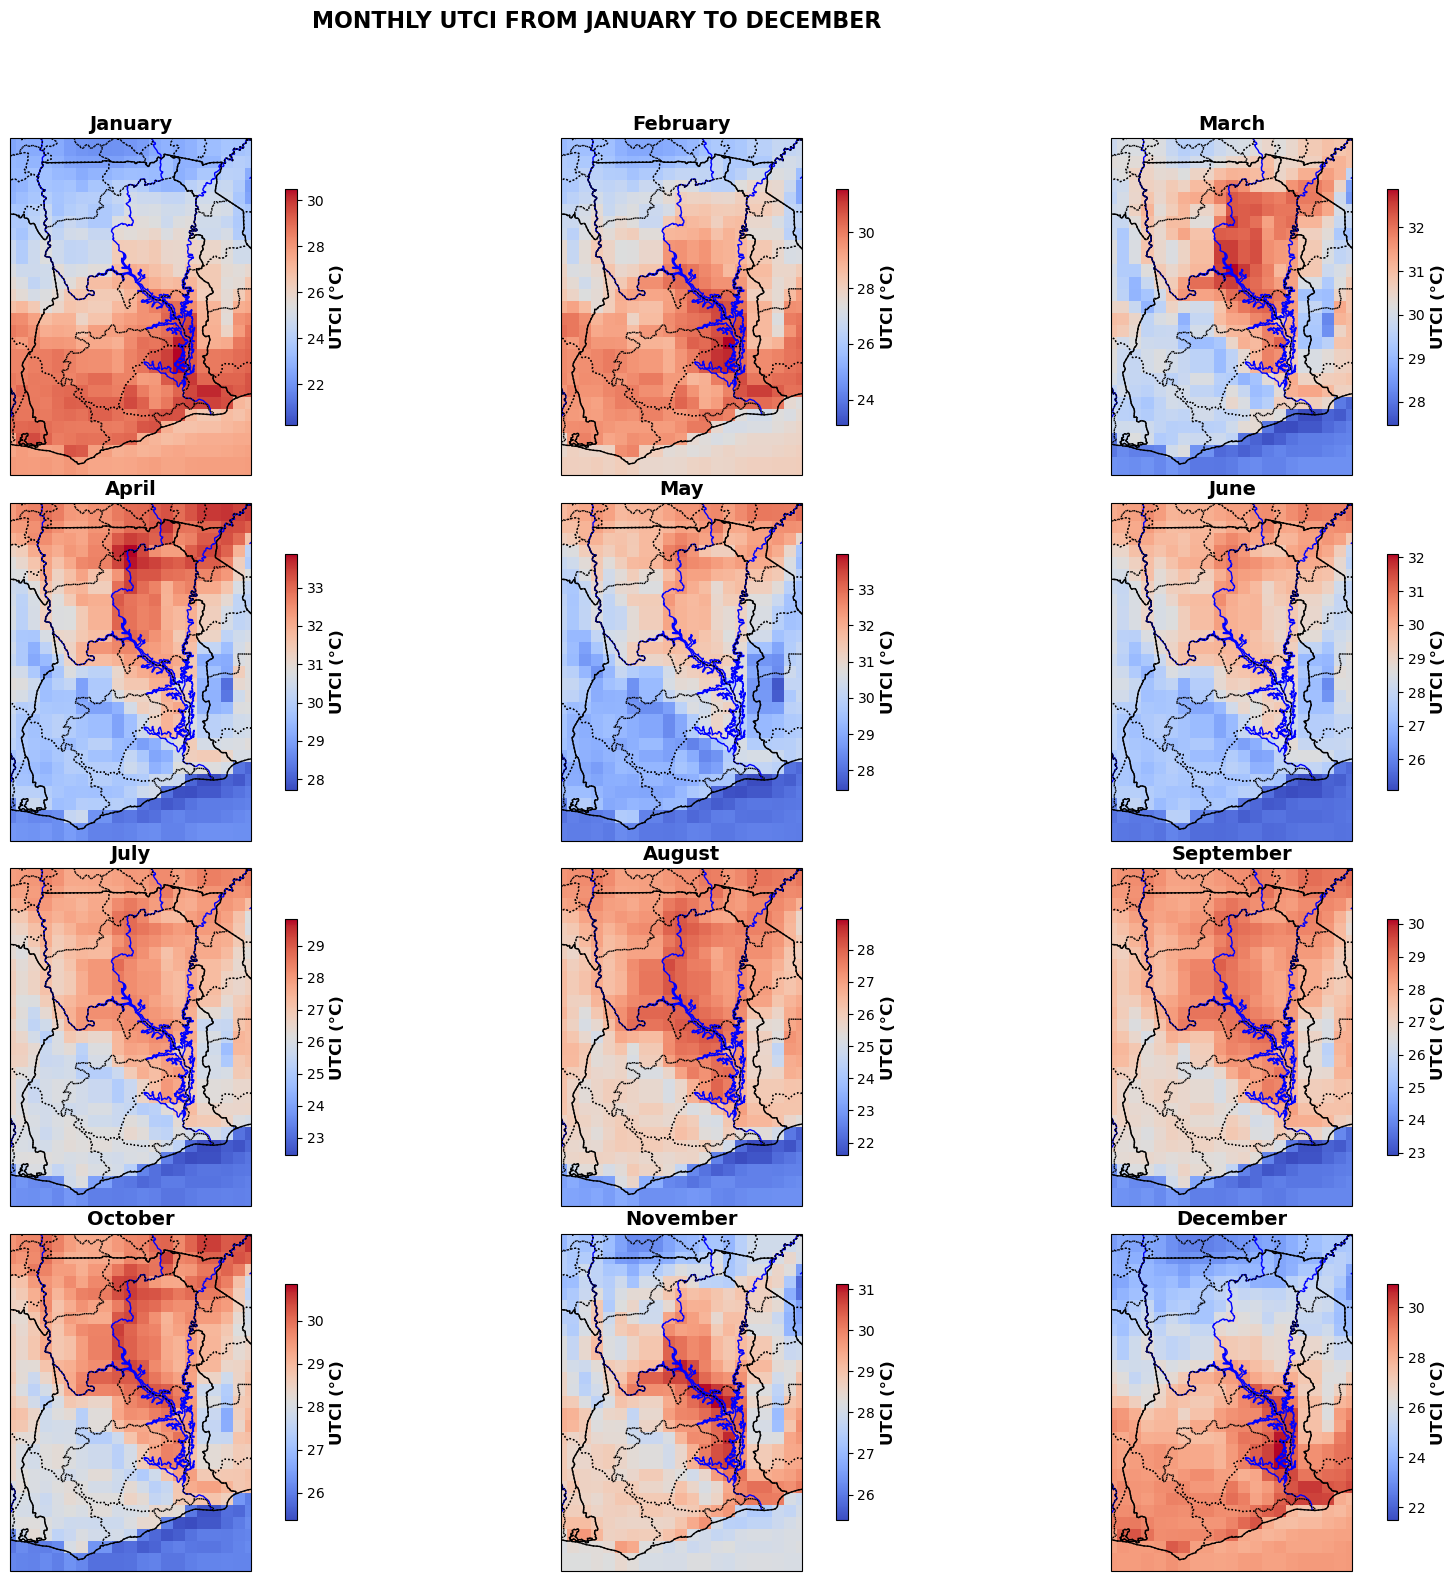

In [27]:
fig, axes = plt.subplots(nrows=4, ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(18, 16))

axes = axes.flatten()
all_months = list(range(1, 13))  

for i, month in enumerate(all_months):
    ax = axes[i]
    month_data = get_month_data(data, month)
    if month_data is not None:
        month_name = get_month_name(month)
        plot_utci(ax, month_data, month_name)

for ax in axes[len(all_months):]:
    ax.axis('off')


fig.tight_layout(pad=0.5)
fig.subplots_adjust(top=0.9)  


fig.suptitle('MONTHLY UTCI FROM JANUARY TO DECEMBER', fontsize=16, fontweight='bold')
#plt.savefig('spatial_plots1.png')
plt.show()

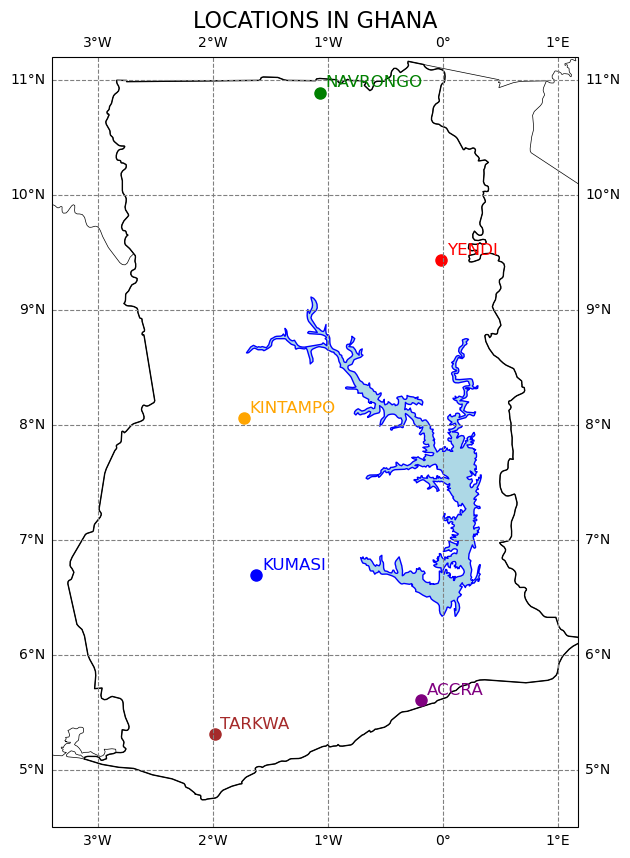

In [8]:
# Coordinates and colors for locations in Ghana
locations = {
    'NAVRONGO': {'coords': (10.891, -1.070), 'color': 'green'},
    'YENDI': {'coords': (9.433, -0.017), 'color': 'red'},
    'KINTAMPO': {'coords': (8.056, -1.730), 'color': 'orange'},
    'KUMASI': {'coords': (6.693, -1.622), 'color': 'blue'},
    'ACCRA': {'coords': (5.6037, -0.187), 'color': 'purple'},
    'TARKWA': {'coords': (5.3076, -1.9847), 'color': 'brown'}
}

# Create the plot
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent to focus on Ghana
ax.set_extent([-3.4, 1.18, 4.5, 11.2], crs=ccrs.PlateCarree())

# Set the background color to white
ax.set_facecolor('white')

# Add cartopy features
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5)
#ax.add_feature(cfeature.RIVERS, edgecolor='blue')
ax.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='lightblue')

# Add geographic features for Ghana
shapefile = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shapefile)
countries = reader.records()
for country in countries:
    if country.attributes['NAME'] == 'Ghana':
        ax.add_geometries([country.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='none')

# Plot each location with the respective color and name
for location, info in locations.items():
    ax.plot(info['coords'][1], info['coords'][0], marker='o', color=info['color'], markersize=8, transform=ccrs.PlateCarree())
    ax.text(info['coords'][1] + 0.05, info['coords'][0] + 0.05, location, fontsize=12, color=info['color'], transform=ccrs.PlateCarree())

# Add title and gridlines
ax.set_title('LOCATIONS IN GHANA', fontsize=16)
ax.gridlines(draw_labels=True, color='gray', linestyle='--')

# Show the plot
#plt.savefig('GHANA(1).png',dpi=500)
plt.show()